# PyTorch and Albumentations for image classification

This example shows how to use Albumentations for image classification. We will use the [`Cats vs. Docs` dataset](https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset). The task will be to detect whether an image contains a cat or a dog.

### Import the required libraries

In [1]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

cudnn.benchmark = True

### Define functions to download an archived dataset and unpack it

In [2]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

### Set the root directory for the downloaded dataset

In [3]:
dataset_directory = os.path.join(os.environ["HOME"], "datasets/cats-vs-dogs")

### Download and extract the `Cats vs. Docs` dataset

In [4]:
filepath = os.path.join(dataset_directory, "kagglecatsanddogs_3367a.zip")
download_url(
    url="https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip",
    filepath=filepath,
)
extract_archive(filepath)

Filepath already exists. Skipping download.


### Split files from the dataset into the train and validation sets

Some files in the dataset are broken, so we will use only those image files that OpenCV could load correctly. We will use 20000 images for training, 4936 images for validation, and 10 images for testing.

In [5]:
root_directory = os.path.join(dataset_directory, "PetImages")

cat_directory = os.path.join(root_directory, "Cat")
dog_directory = os.path.join(root_directory, "Dog")

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:20000]
val_images_filepaths = correct_images_filepaths[20000:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

20000 4936 10


### Define a function to visualize images and their labels

Let's define a function that will take a list of images' file paths and their labels and visualize them in a grid. Correct labels are colored green, and incorrectly predicted labels are colored red.

In [6]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

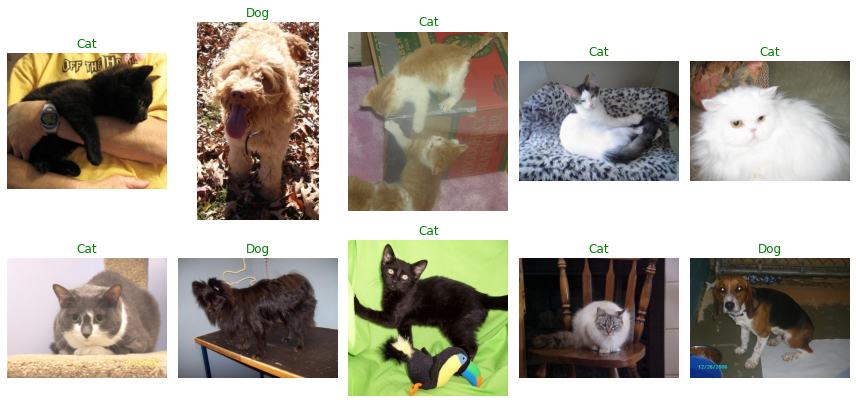

In [7]:
display_image_grid(test_images_filepaths)

### Define a PyTorch dataset class

Next, we define a PyTorch dataset. If you are new to PyTorch datasets, please refer to this tutorial - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html.

Out task is binary classification - a model needs to predict whether an image contains a cat or a dog. Our labels will mark the probability that an image contains a cat. So the correct label for an image with a cat will be `1.0`, and the correct label for an image with a dog will be `0.0`.

`__init__` will receive an optional `transform` argument. It is a transformation function of the Albumentations augmentation pipeline. Then in `__getitem__`, the Dataset class will use that function to augment an image and return it along with the correct label.

In [8]:
class CatsVsDogsDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "Cat":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

### Use Albumentations to define transformation functions for the train and validation datasets

We use Albumentations to define augmentation pipelines for training and validation datasets. In both pipelines, we first resize an input image, so its smallest size is 160px, then we take a 128px by 128px crop. For the training dataset, we also apply more augmentations to that crop. Next, we will normalize an image. We first divide all pixel values of an image by 255, so each pixel's value will lie in a range `[0.0, 1.0]`. Then we will subtract mean pixel values and divide values by the standard deviation. `mean` and `std` in augmentation pipelines are taken from the [`ImageNet` dataset](http://www.image-net.org/). Still, they transfer reasonably well to the `Cats vs. Dogs` dataset. After that, we will apply `ToTensorV2` that converts a NumPy array to a PyTorch tensor, which will serve as an input to a neural network.

Note that in the validation pipeline we will use `A.CenterCrop` instead of `A.RandomCrop` because we want out validation results to be deterministic (so that they will not depend upon a random location of a crop).

In [9]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = CatsVsDogsDataset(images_filepaths=train_images_filepaths, transform=train_transform)

In [10]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = CatsVsDogsDataset(images_filepaths=val_images_filepaths, transform=val_transform)

Also let's define a function that takes a dataset and visualizes different augmentations applied to the same image.

In [11]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

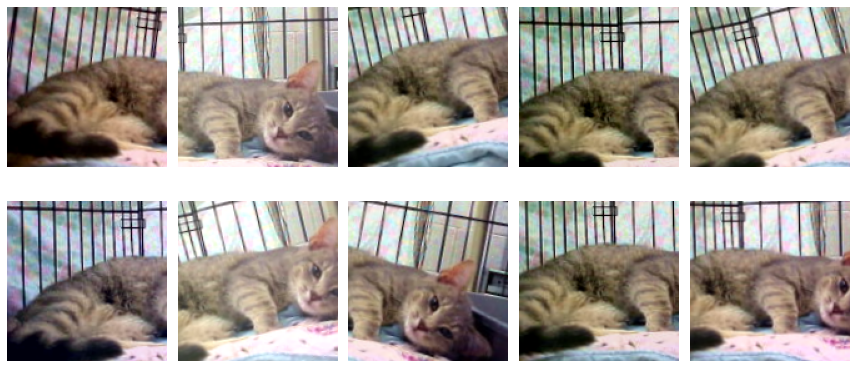

In [12]:
random.seed(42)
visualize_augmentations(train_dataset)

### Define helpers for training

We define a few helpers for our training pipeline. `calculate_accuracy` takes model predictions and true labels and will return accuracy for those predictions. `MetricMonitor` helps to track metrics such as accuracy or loss during training and validation

In [13]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [14]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

### Define training parameters 

Here we define a few training parameters such as model architecture, learning rate, batch size, epochs, etc

In [15]:
params = {
    "model": "resnet50",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 4,
    "epochs": 10,
}

### Create all required objects and functions for training and validation

In [16]:
model = getattr(models, params["model"])(pretrained=False, num_classes=1,)
model = model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [17]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [18]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [19]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

### Train a model

In [20]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.700 | Accuracy: 0.598: 100%|██████████| 313/313 [00:38<00:00,  8.04it/s]
Epoch: 1. Validation. Loss: 0.684 | Accuracy: 0.663: 100%|██████████| 78/78 [00:03<00:00, 23.46it/s]
Epoch: 2. Train.      Loss: 0.611 | Accuracy: 0.675: 100%|██████████| 313/313 [00:37<00:00,  8.24it/s]
Epoch: 2. Validation. Loss: 0.581 | Accuracy: 0.689: 100%|██████████| 78/78 [00:03<00:00, 23.25it/s]
Epoch: 3. Train.      Loss: 0.513 | Accuracy: 0.752: 100%|██████████| 313/313 [00:38<00:00,  8.22it/s]
Epoch: 3. Validation. Loss: 0.408 | Accuracy: 0.818: 100%|██████████| 78/78 [00:03<00:00, 23.61it/s]
Epoch: 4. Train.      Loss: 0.440 | Accuracy: 0.796: 100%|██████████| 313/313 [00:37<00:00,  8.24it/s]
Epoch: 4. Validation. Loss: 0.374 | Accuracy: 0.829: 100%|██████████| 78/78 [00:03<00:00, 22.89it/s]
Epoch: 5. Train.      Loss: 0.391 | Accuracy: 0.821: 100%|██████████| 313/313 [00:37<00:00,  8.25it/s]
Epoch: 5. Validation. Loss: 0.345 | Accuracy: 0.853: 100%|██████████| 78/78 [00:0

### Predict labels for images and visualize those predictions

Now we have a trained model, so let's try to predict labels for some images and see whether those predictions are correct. First we make the `CatsVsDogsInferenceDataset` PyTorch dataset. Its code is similar to the training and validation datasets, but the inference dataset returns only an image and not an associated label (because in the real world we usually don't have access to the true labels and want to infer them using our trained model).

In [21]:
class CatsVsDogsInferenceDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image

test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_dataset = CatsVsDogsInferenceDataset(images_filepaths=test_images_filepaths, transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [22]:
model = model.eval()
predicted_labels = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(params["device"], non_blocking=True)
        output = model(images)
        predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
        predicted_labels += ["Cat" if is_cat else "Dog" for is_cat in predictions]

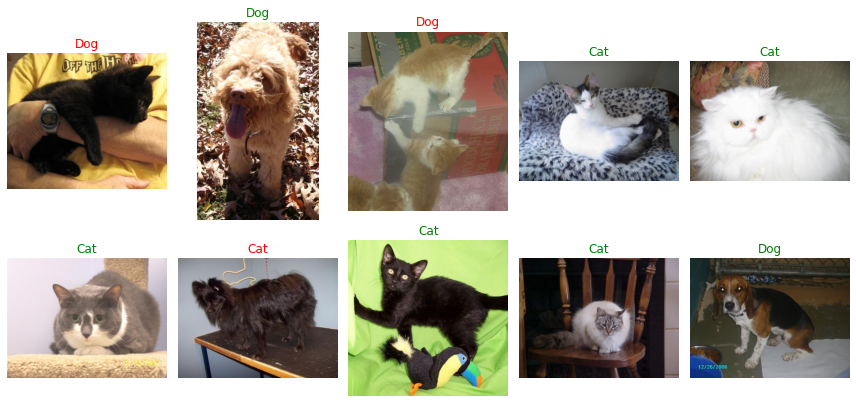

In [23]:
display_image_grid(test_images_filepaths, predicted_labels)

As we see our model predicted correct labels for 7 out of 10 images. If you train the model for more epochs, you will obtain better results.